# Import packages and define functions

In [1]:
# data visualiztion
import matplotlib.pyplot as plt
import seaborn as sns

# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
from statsmodels.formula.api import ols
import scipy.stats as stats

# Feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

# model validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score

# Variance inflation factor, mean abs/squarred error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")

# make stuff look cooler
plt.style.use('fivethirtyeight')

In [2]:
# creates dictionary of variance inflation factors. 
def create_vif_list(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    good_vifs = []
    bad_vifs = []

    for k,v in vif_dict.items():
        if v < 10:
            good_vifs.append(k)
        else:
            bad_vifs.append(k)

    return good_vifs,bad_vifs

def create_vif_dictionary(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    return vif_dict

# create a dictionary showing the adjusted R-squared values for each feature individually
def create_R2_dictionary(X,y):

    adj_R_squares = {}

    for feature in X.columns:
        predictors_int = sm.add_constant(X[feature])
        model = sm.OLS(y,predictors_int).fit()
        adj_R_square = float(model.summary2().tables[0][3][0])
        adj_R_squares[feature] = adj_R_square
        
    return adj_R_squares

# author's docstring is in a markup cell down below in the stepwise selection section
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)

    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature_name = included[worst_feature]
            included.pop(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature_name, worst_pval))
        if not changed:
            break
    return included

# recursive feature elimination
def run_RFE(X,y,n=1):

    linreg = LinearRegression()
    selector = RFE(linreg,n_features_to_select=n)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass
    return selections, rankers

# recuersive feature elimination with cross validation
def run_RFECV(X,y,select_rank=False):

    linreg = LinearRegression()
    selector = RFECV(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass

    if select_rank == True:
        return selections
    else:
        return rankers

# returns OLS linear regression model
def run_OLS_model(X,y):

    predictors_int = sm.add_constant(X)
    model = sm.OLS(y,predictors_int).fit()

    return model

# returns dictionary: keys are column labels, values are count of NaN values present
def create_NaN_dictionary(X):

    NaN_dict = {}

    for feature in X.columns:
        NaN_dict[feature] = sum(X[feature].isna())

    return NaN_dict

def create_CC_df(X,minimum=0,maximum=1):

    cor_df=X.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    cor_df['pairs'] = list(zip(cor_df.level_0, cor_df.level_1))
    cor_df.set_index(['pairs'], inplace = True)
    cor_df.drop(columns=['level_1', 'level_0'], inplace = True)
    cor_df.columns = ['cc']
    cor_df.drop_duplicates(inplace=True)
    cor_df = cor_df[(cor_df.cc>minimum) & (cor_df.cc < maximum)]
    
    return cor_df

def model_strength_indicators(model):
    indicator_dict = {
    'r_squared':model.summary2().tables[0][3][0],
    'skew':model.summary2().tables[2][1][2],
    'kurtosis':model.summary2().tables[2][1][3],
    'Durbin Watson':model.summary2().tables[2][3][0],
    'Jarque-Bera':model.summary2().tables[2][3][1],
    'P value':model.summary2().tables[2][3][2],
    'Condition':model.summary2().tables[2][3][3]
    }
    return indicator_dict


# Import data and prepare for exploration

In [3]:
data = pd.read_csv('data/kc_house_data.csv')
data.drop(data.loc[data['sqft_basement']=='?'].index,inplace=True) # remove '?' from the data.

##### Make object types numerical

In [4]:
# convert all string types into np floats
data.sqft_basement = [float(sq) for sq in list(data.sqft_basement)]

# Replaces grade strings with numerics based on data dict. 
grade_raws = list(data.grade.unique())
# replaces a cell value with the int of the first character of its existing string
for raw in grade_raws:
    data.grade.replace(to_replace=raw,value=int(raw[0]),inplace=True)

# replaces condition objects with numerics based on data dict.
condition_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
for key in condition_dict:
    data.condition.replace(to_replace=condition_dict,inplace=True)

# replace yr_built NaNs with numeric 0
data.yr_renovated.replace(to_replace=np.nan,value=0,inplace=True)

# convert waterfront into numeric boolean
waterfront_bool_list = []

for value in data.waterfront:
    if value == 'YES':
        waterfront_bool_list.append(1)
    else:
        waterfront_bool_list.append(0)
        
data.waterfront = waterfront_bool_list

# convert view from string into categorical ordinal
view_rank_list = [] 
view_dict = {'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}

for value in data.view:
    if value in list(view_dict.keys()):
        view_rank_list.append(view_dict[value])
    else:
        view_rank_list.append(0)
        
data.view = view_rank_list


# convert dates into ordinals 
data.date = pd.to_datetime(data['date'])
data.date = data['date'].map(dt.datetime.toordinal)

In [5]:
# inspect data for any object types 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  int64  
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  int64  
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  sqft_basement  21143 non-null  float64
 14  yr_built       21143 non-null  int64  
 15  yr_renovated   21143 non-null  float64
 16  zipcode        21143 non-null  int64  
 17  lat            21143 non-null  float64
 18  long  

In [6]:
# declare target and predictor variables
y = data.price 
X = data.drop('price',axis=1)

# Create and visualize a baseline

#### First round of feature selection and elimination
- First select features based on P values using a forward-backward stepwise selection. 
- Then perform feature ranking with recursive feature elimination with cross validation.
- Finally eliminate highly colinear features based on variance inflation factor and correlation coefficients.

In [7]:
# stepwise feature elmination
stepwise_selected = stepwise_selection(X,y,verbose=False)
X_base = X[stepwise_selected]

In [8]:
# recursive feature elimination
RFE_selection = run_RFECV(X_base,y)
X_base = X_base[RFE_selection]

In [9]:
# inspecting multicolinearity 

# eliminate features base on variance inflation factor
good,bad = create_vif_list(X_base)
X_base = X_base[good]


In [10]:
# not eliminating sqft_lot or sqft_lot15because the correlation coefficient is less than .75, I suspect at least one will be weeded out later on anyway. 
cc_df = create_CC_df(X_base,.6,1)
cc_df

,cc
pairs,
"(sqft_lot, sqft_lot15)",0.720649


In [11]:
base_model = run_OLS_model(X_base,y)
base_resid = base_model.resid

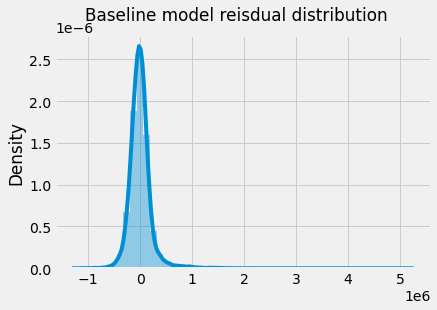

In [12]:
sns.distplot(base_resid)
plt.suptitle("Baseline model reisdual distribution")
plt.show()

In [13]:
base_model_strength = model_strength_indicators(base_model)
base_model_strength

{'r_squared': '0.626',
 'skew': '3.821',
 'kurtosis': '54.175',
 'Durbin Watson': '1.994',
 'Jarque-Bera': '2358627.117',
 'P value': '0.000',
 'Condition': '5099993113'}

##### Observations:

Data is clearly not normally distributed. First step is to investigate impact of elimating outliers within the target variable based on the statistical maximum (IQR * 1.5)

In [14]:
std_thresh = data.price.std()*3 # three standard deviations 
std_cap = data.loc[abs(data['price']) <= std_thresh] # slicing all data within the defined range

#re-declare X and y variables
y = std_cap.price
X = std_cap[X_base.columns]

Inspect resulting model 

In [15]:
# build model and grab residuals
outlier_model = run_OLS_model(X,y)
outlier_residual = outlier_model.resid

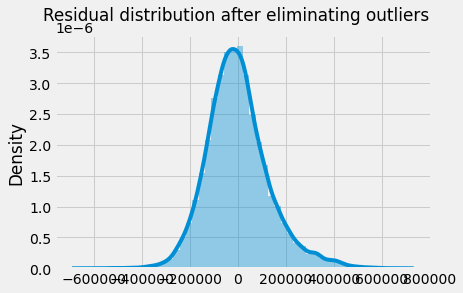

In [16]:
# visualize model residuals
sns.distplot(outlier_residual)
plt.suptitle('Residual distribution after eliminating outliers')
plt.show()

In [17]:
outlier_strength = model_strength_indicators(outlier_model)
outlier_strength

{'r_squared': '0.607',
 'skew': '0.589',
 'kurtosis': '4.241',
 'Durbin Watson': '1.974',
 'Jarque-Bera': '2435.491',
 'P value': '0.000',
 'Condition': '5108350008'}

Observations: 
- Indicators of normality slightly improved but still needs work.
- skew is close to zero, kurtosis is slightly heavy
- r-squared has improved
- jarque-bera is fairly high
- some signs of multi-colinearity

Next step is to investigate the impact of log transforming the target variable

In [18]:
# create log transformed target variable
y_log = np.log(y)

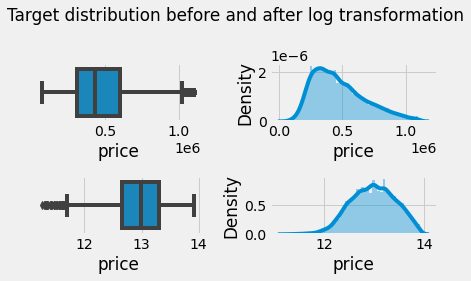

In [19]:
fig,axes = plt.subplots(2,2)

sns.boxplot(y,ax=axes[0,0]) # boxplot before
sns.distplot(y,ax=axes[0,1]) # distplot before

sns.boxplot(y_log,ax=axes[1,0]) # boxplot after
sns.distplot(y_log,ax=axes[1,1]) # boxplot after

fig.suptitle("Target distribution before and after log transformation")
plt.tight_layout()
plt.show()

Continue feature ranking, selection and elimination with log transformed target variable

In [20]:
stepwise_selected = stepwise_selection(X,y_log,verbose=False)
X = X[stepwise_selected]

In [21]:
RFE_selection = run_RFECV(X,y)
X = X[RFE_selection]

In [22]:
good,bad = create_vif_list(X)
X = X[good]

In [23]:
outlier_cor_df = create_CC_df(X,.6,1)
outlier_cor_df

,cc
pairs,


In [24]:
log_model = run_OLS_model(X,y_log)
log_residuals = log_model.resid

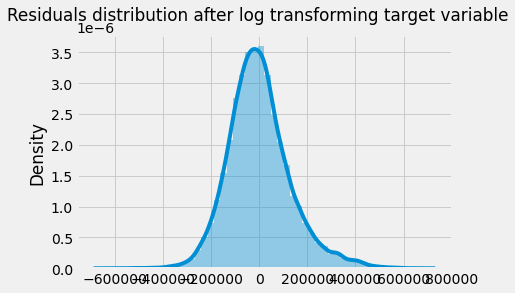

In [25]:
# visualize model residuals
sns.distplot(outlier_residual)
plt.suptitle('Residuals distribution after log transforming target variable')
plt.show()

In [26]:
log_model_strength = model_strength_indicators(log_model)
log_model_strength

{'r_squared': '0.635',
 'skew': '-0.154',
 'kurtosis': '3.759',
 'Durbin Watson': '1.986',
 'Jarque-Bera': '557.856',
 'P value': '0.000',
 'Condition': '5107081200'}

Observations: After eliminating outliers, log transforming the target variable, and another round of feature selection and elimination. 
- The model continues to improve. 
- Next steps will be to Engineer new features and investigate how they impact the model performance. 

# Engineering new features to further improve the model

- First new features will be engineered by joining IRS data on income by zipcode.
- two categorical variables will be one-hot encoded (waterfront location, and tax bracket)  
- Lastly, new feature may be developed by interpolating existing feature of data. 

Features created from joining external data

In [27]:
# Dictionary with zipcodes associated with waterfronts described by the data dictionary
water_loc_dict = {'Duwamish':[98168],
'Elliott Bay':[98119,98104,98129,98132,98127,98125,98195,98101,98134,98170,98139,98131,98181], 
'Puget Sound':[98071,98083,98013,98070,98031,98131,98063,98195,98207,98190], 
'Lake Union':[98109], 
'Ship Canal':[00000], 
'Lake Washington':[98072,98077], 
'Lake Sammamish':[98074,98075,98029], 
'other lake':[00000], 
'river/slough waterfronts':[00000]}

# list to contain new column data
waterfront_list = []

# for loop to assign waterfront based on zipcode
for zipcode in X.zipcode:
    for k,v in water_loc_dict.items():
        if zipcode in v:
            waterfront_list.append(k)
            appended = True
            break
        else: 
            appended = False
    if not appended:
        waterfront_list.append('NONE')

# print(len(waterfront_list),set(waterfront_list))
X['waterfront_loc'] = waterfront_list

In [28]:
# IRS income tax data from data.world 
# https://data.world/jonloyens/irs-income-by-zip-code/workspace/query?queryid=0491f7ff-f7e5-49be-ad8c-8047d6a54c57

income = pd.read_csv('data/irs_income_by_zipcode.csv')

income.avg_taxable_income = income.avg_taxable_income*1000 # scaling data back to dollar units (was in thousands)
income.taxable_income_amount = income.taxable_income_amount*1000 
income.rename({'taxable_income_amount':'zip_tax_revenue'},axis=1,inplace=True) # renaming to something more idiomatic

# # create lists to stage data in order to concat new columns later
joint_filing_bracket = [] #for the joint filing tax schedule

# there is probably a more "pythony" way to do this for loop but it works so I'm not touching it 
for average in income.avg_taxable_income:
    if average > 628301:
        joint_filing_bracket.append(7)
    elif average <= 19900:
        joint_filing_bracket.append(1)
    elif (average >= 19901) and (average <= 81050):
        joint_filing_bracket.append(2)
    elif (average >= 81051) and (average <= 172750):
        joint_filing_bracket.append(3)
    elif (average >= 172751) and (average <= 329850):
        joint_filing_bracket.append(4)
    elif (average >= 329851) and (average <= 418850):
        joint_filing_bracket.append(5)
    elif (average >= 418851) and (average <= 628300):
        joint_filing_bracket.append(6)

# assign discovered data to new column
income['joint_filing_tax_bracket'] = joint_filing_bracket

# create dictionary of zipcodes with corresponding tax bracket
# dictionary will be used to assign create similar columns in the principal data.
joint_filing_tax_dict = {}
tax_revenue_dict = {}

# create ditionaries to later assign values to principal data
for row in income.iterrows():
    joint_filing_tax_dict[row[1][0]] = row[1][3]
    tax_revenue_dict[row[1][0]] = row[1][1]

# concat columns to X containing tax bracket based on single and joint filing federal income tax schedule
X['income_tax_bracket'] = X.zipcode.replace(to_replace=joint_filing_tax_dict) # joint filing
X['zip_tax_revenue'] = X.zipcode.replace(to_replace=tax_revenue_dict)


In [29]:
# create dummy variables
waterfront_dummies = pd.get_dummies(X.waterfront_loc,prefix='waterfront',prefix_sep='_').drop('waterfront_NONE',axis=1)
bracket_dummies = pd.get_dummies(X.income_tax_bracket,drop_first=True,prefix='income_tax',prefix_sep='_')

# reasign X to concatenated dataframe, dropping features no longer needed
X = X.drop(['waterfront_loc','zipcode'],axis=1)
X = pd.concat([X,bracket_dummies,waterfront_dummies],axis=1)

### create baseline for engineered features

In [30]:
hot_base = run_OLS_model(X,y_log)
resid = hot_base.resid

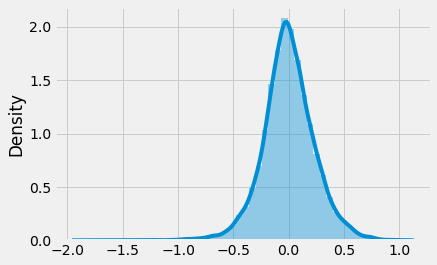

In [31]:
sns.distplot(resid)
plt.show()

In [32]:
hot_base_stregnth = model_strength_indicators(hot_base)
hot_base_stregnth

{'r_squared': '0.721',
 'skew': '-0.132',
 'kurtosis': '4.627',
 'Durbin Watson': '1.991',
 'Jarque-Bera': '2260.617',
 'P value': '0.000',
 'Condition': '2448127845425563'}

Continue to rank, select and eliminate features. 

In [33]:
stepwise_selections = stepwise_selection(X,y_log,verbose=False)
X = X[stepwise_selections]

In [34]:
rfecv_selections = run_RFECV(X,y_log)
X = X[rfecv_selections]

In [35]:
good,bad = create_vif_list(X)
X = X[good[1:]]

In [36]:
hot_model = run_OLS_model(X,y_log)
hot_residuals = hot_model.resid

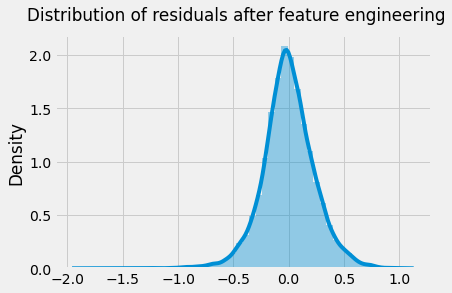

In [37]:
sns.distplot(hot_residuals)
plt.suptitle('Distribution of residuals after feature engineering')
plt.show()

In [38]:
hot_model_strength = model_strength_indicators(hot_model)
hot_model_strength

{'r_squared': '0.721',
 'skew': '-0.132',
 'kurtosis': '4.627',
 'Durbin Watson': '1.991',
 'Jarque-Bera': '2261.552',
 'P value': '0.000',
 'Condition': '8370405319225'}

Continue eliminating features manually to address remaining multi-colinearity and further fit the model 

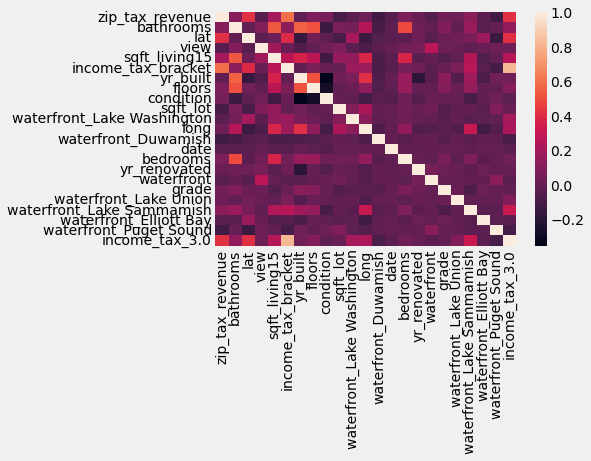

In [39]:
cor = X.corr()
sns.heatmap(cor,xticklabels=cor.columns,
        yticklabels=cor.columns)
plt.show()

In [40]:
correlations = create_CC_df(X,minimum=0.5)

In [41]:
correlations

,cc
pairs,
"(income_tax_3.0, income_tax_bracket)",0.819029
"(zip_tax_revenue, income_tax_bracket)",0.591402
"(bathrooms, yr_built)",0.546328
"(sqft_living15, bathrooms)",0.528819
"(floors, yr_built)",0.511731
"(bathrooms, floors)",0.503769


In [42]:
vif_dict = create_vif_dictionary(X)
vif_dict

{'const': 0.0,
 'zip_tax_revenue': 1.8665587267888675,
 'bathrooms': 2.393104712203311,
 'lat': 1.5733081531958377,
 'view': 1.1957267557869113,
 'sqft_living15': 1.8032233171630219,
 'income_tax_bracket': 4.066703503307171,
 'yr_built': 2.373590149133733,
 'floors': 1.5912028289288376,
 'condition': 1.2397168818937374,
 'sqft_lot': 1.1086880392325986,
 'waterfront_Lake Washington': 1.1773902145130513,
 'long': 1.5786470936856898,
 'waterfront_Duwamish': 1.0360759029812119,
 'date': 1.0079725742163328,
 'bedrooms': 1.4235749385801386,
 'yr_renovated': 1.1064741918751255,
 'waterfront': 1.1048502494147314,
 'grade': 1.0615084610220635,
 'waterfront_Lake Union': 1.0209829961015247,
 'waterfront_Lake Sammamish': 1.2584373468345982,
 'waterfront_Elliott Bay': 1.0588702231805591,
 'waterfront_Puget Sound': 1.0596320752199788,
 'income_tax_3.0': 3.481605196544053}

In [43]:
# manually eliminating features based on VIF, and colinearity coefficient
X = X.drop(['income_tax_3.0','income_tax_bracket','yr_built'],axis=1)

In [44]:
new_model = run_OLS_model(X,y_log)
new_residuals = new_model.resid

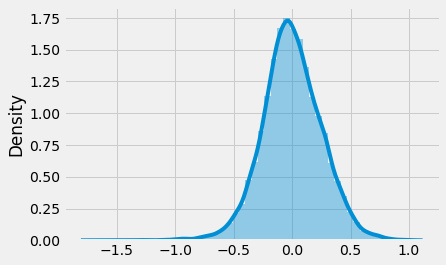

In [45]:
sns.distplot(new_residuals)
plt.show()

In [46]:
new_model_strength = model_strength_indicators(new_model)

# Review model performance across iterations
Features are ranked, selected and eliminated through each iteration using the same selection pattern: first selection and elimination based on p-value using a forward-backward stepwise selection method, second selction and elimination based on feature "importance" using recursive feature elimination with cross validation. third selection and elimination based on multi-colinearity determined first by variance inflation factor and second using colinearity coefficients.

- base_model_strength: all original data features, all numerical datatypes, no NaN values
- outlier_strength: records where the target variable (price) is more than three standard deviations away from the target mean. 
- log_model_strength: target variable has been log transformed (regression coefficients now represent change in percentage, not original units of feature).
- hot_model_strength: New features engineered from original data set and and auxilary data set, two categorical variables are one-hot-encoded.
- new_model_strength: Some features are eliminated manually to achieve better normality. 

Baseline model strength after firs round of feature selection and elimination

In [47]:
base_model_strength

{'r_squared': '0.626',
 'skew': '3.821',
 'kurtosis': '54.175',
 'Durbin Watson': '1.994',
 'Jarque-Bera': '2358627.117',
 'P value': '0.000',
 'Condition': '5099993113'}

Model strength after eliminating outliers. 

In [48]:
outlier_strength

{'r_squared': '0.607',
 'skew': '0.589',
 'kurtosis': '4.241',
 'Durbin Watson': '1.974',
 'Jarque-Bera': '2435.491',
 'P value': '0.000',
 'Condition': '5108350008'}

- R-squared; explanation of variance slightly decreases
- Normality in general significantly improves
- Homoscedasticity slightly decreases
- Condition increased by a large number but its less than one hundreth of a percent. 

Model strength after target variable log transformation

In [49]:
log_model_strength

{'r_squared': '0.635',
 'skew': '-0.154',
 'kurtosis': '3.759',
 'Durbin Watson': '1.986',
 'Jarque-Bera': '557.856',
 'P value': '0.000',
 'Condition': '5107081200'}

- R-squared; explanation of variance improves
- Normality in general improves
- Homoscedasticity slightly improves
- Condition improved (decreased) but only by about three thousandths of a percent.  

Model Strength after engineering new features including joining new data and one-hot encoding.

In [50]:
hot_model_strength

{'r_squared': '0.721',
 'skew': '-0.132',
 'kurtosis': '4.627',
 'Durbin Watson': '1.991',
 'Jarque-Bera': '2261.552',
 'P value': '0.000',
 'Condition': '8370405319225'}

- R-squared; explanation of variance improves significantly (best so far)
- Normality in general decreses; skewness imrpoves, kurtosis and jarque-bera increase significantly.
- Homoscedasticity slightly improves.
- Condition worsened (increased) significantly.

Model strength after manual feature elimination

In [51]:
new_model_strength

{'r_squared': '0.678',
 'skew': '-0.061',
 'kurtosis': '3.811',
 'Durbin Watson': '1.991',
 'Jarque-Bera': '560.561',
 'P value': '0.000',
 'Condition': '8345178480742'}

- R-squared; explanation of variance decreases slightly
- Normality in general improves; skewness is nearly 0, kurtosis improves.
- Homoscedasticity slightly improves.
- Condition improves by three thousandths of a percent, however condition is 1600% of the condition of the log_model.

# Model validation

In [52]:
# create a train and a test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2)

# generate predictions based on test and train sampels
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# calculate train and test residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

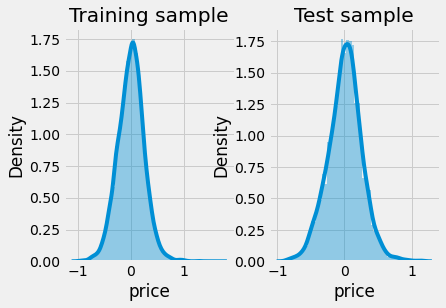

<Figure size 1440x1440 with 0 Axes>

In [53]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.distplot(train_residuals,ax=ax1)
ax1.set_title('Training sample')
sns.distplot(test_residuals,ax=ax2)
ax2.set_title('Test sample')

plt.figure(figsize=(20,20))
plt.show()


In [54]:
# calculate train and test mean squared error 
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print('Difference: ', abs(train_mse - test_mse))

Train Mean Squarred Error: 0.06309105260187797
Test Mean Squarred Error: 0.06494116547941643
Difference:  0.0018501128775384595


In [55]:
cv_5_results  = np.mean(cross_val_score(linreg, X, y_log, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y_log, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y_log, cv=20, scoring='neg_mean_squared_error'))

print('Five k-fold MSE: ', cv_5_results)
print('Ten k-fold MSE: ', cv_10_results)
print('Twenty k-fold MSE: ', cv_20_results)


Five k-fold MSE:  -0.06375460998124424
Ten k-fold MSE:  -0.06374013600321765
Twenty k-fold MSE:  -0.06367065474702942


#### observations on model validation
The mean squared error (MSE), a statistic representing the amount of error in a the model (i.e. how well the regression line fits the data), is calculated to be roughly the same using both a simple train-test split and the k-fold cross validation technique. The MSE is close to zero indicating the model fits the data well, and the model probably fits the real population data also. 

# Final observations

In [56]:
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     2104.
Date:                Sun, 10 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:08:11   Log-Likelihood:                -801.26
No. Observations:               19982   AIC:                             1645.
Df Residuals:                   19961   BIC:                             1810.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -206.1090     11.813    -17.447      0.000    -229.264    -182.954
zip_tax_revenue             1.623e-10   3.34e-12     48.628      0.000    1.56e-10    1.69e-10
bathrooms                      0.1230      0.004     34.081      0.000       0.116       0.130
lat                            1.2111      0.015     80.687      0.000       1.182       1.240
view                           0.0822      0.003     26.972      0.000       0.076       0.088
sqft_living15                  0.0003   3.88e-06     64.867      0.000       0.000       0.000
floors                         0.0742      0.004     18.432      0.000       0.066       0.082
condition                      0.0799      0.003     27.306      0.000       0.074       0.086
sqft_lot                     1.14e-06   4.66e-08     24.484      0.000    1.05e-06    1.23e-06
waterfront_Lake Washington    -0.1090      0.013     -8.459      0.000      -0.134      -0.084
long                          -0.2703      0.015    -18.155      0.000      -0.299      -0.241
waterfront_Duwamish           -0.2061      0.016    -12.930      0.000      -0.237      -0.175
date                           0.0002   1.58e-05     10.898      0.000       0.000       0.000
bedrooms                       0.0239      0.002     10.294      0.000       0.019       0.028
yr_renovated                7.942e-05   5.25e-06     15.118      0.000    6.91e-05    8.97e-05
waterfront                     0.2598      0.038      6.927      0.000       0.186       0.333
grade                          0.0065      0.001      5.604      0.000       0.004       0.009
waterfront_Lake Union          0.2971      0.028     10.618      0.000       0.242       0.352
waterfront_Lake Sammamish      0.1230      0.009     14.088      0.000       0.106       0.140
waterfront_Elliott Bay         0.0345      0.011      3.055      0.002       0.012       0.057
waterfront_Puget Sound        -0.0582      0.013     -4.336      0.000      -0.085      -0.032
==============================================================================
Omnibus:                      299.780   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              560.561
Skew:                          -0.061   Prob(JB):                    1.89e-122
Kurtosis:                       3.811   Cond. No.                     8.35e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.35e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
legend = {'zip_tax_revenue': 'For every $100,000 in tax revenue for a given zipcode, the price of a property increases by 0.00001623 %.',
 'bathrooms': 'For every additional bathroom, the price of a property increases by 0.1230 %.',
 'lat': 'For every additional degree north, the price of a property increases by 1.2111 %.',
 'view': 'For each additional point (0-4), the price of a property increases by 0.0822 %. ',
 'sqft_living15': 'For every additional average square foot for the nearest 15 houses, the price of a property increases by 0.0003 %.',
 'floors': 'For every additional floor, the price of a property increases by 0.0742 %.',
 'condition': 'For each additional point (1-5), the price of a property increases by 0.0799 %. ',
 'sqft_lot': 'For every 100 square feet (for the whole lot), the price of a property increases by 0.00011400 %.',
 'waterfront_Lake Washington': 'If the property is at or near lake washington, the price of the property decreases by 0.1090 %.',
 'long': 'For every additional degree to the east, the price of a property decreases by 0.2703 %.',
 'waterfront_Duwamish': 'If the property is at or near Duwamish, the price of the property decreases by 0.2061 %.',
 'date': 'For every day closer to the present that a property was sold, the price increases by 0.002 %.',
 'bedrooms': 'For every additional bedroom the price of a property increases by 0.0239 %.',
 'yr_renovated': 'For every year closer to the present that a house was renovated, the price of the property increases by 0.00007942 %.',
 'waterfront': 'If the property is on a waterfront, the price increases by 0.2598 %.',
 'grade': 'For each additional point (1-11) the price of a property increases by 0.0065 %.',
 'waterfront_Lake Union': 'If the property is at or near Lake Union, the price of the property increases by 0.2971 %.',
 'waterfront_Lake Sammamish': 'If the property is at or near Lake Sammamish, the price of the property increases by 0.1230 %.',
 'waterfront_Elliott Bay': 'If the property is at or near Elliott Bay, the price of the property increases by 0.0345 %.',
 'waterfront_Puget Sound': 'If the property is at or near Puget Sound, the price of the property decreases by 0.0582 %.'}